### Initial settings

In [1]:
#-- Import general libraries
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices # Comment out this line if runing on GPU cluster
import numpy as np 
import pandas as pd
import time 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import wandb

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{5}"

In [3]:
# Check if GPU is available 
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print(f"Is GPU available? {is_gpu}")

# If GPU is available, print additional information
if is_gpu:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"GPU Device Name: {device_name}")
    print(f"GPU Device Index: {current_device}")

Is GPU available? True
GPU Device Name: GeForce RTX 2080 Ti
GPU Device Index: 0


#### Filters

In [4]:
# # # ################################### # # #
# # # ######   Numerial parameters ###### # # #
# # # ################################### # # #
c = 1  # speed of sound 1m/s
courant_number = 0.1

# # # ################################### # # #
# # # ######    Linear Filter      ###### # # #
# # # ################################### # # #




filter = torch.tensor([[0.0, -1.0, 0.0],
       [-1.0, 4.0, -1.0],
       [0.0, -1.0, 0.0]])



advection_operator_x = torch.tensor([[0.0, 0.0, 0.0],
       [0.5, 0.0, -0.5],
       [0.0, 0.0, 0.0]])

advection_operator_y = torch.tensor([[0.0, -0.5, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.5, 0.0]])

print(filter)
print(filter.shape)

tensor([[ 0., -1.,  0.],
        [-1.,  4., -1.],
        [ 0., -1.,  0.]])
torch.Size([3, 3])


##### 7*7 Cubic

In [5]:
# 7*7
data_str = """-1.0975826519729831E-003   6.6388197653750505E-003  -3.1874333451830800E-002   4.1414859580519367E-003  -3.1874333451830786E-002   6.6388197653750435E-003  -1.0975826519729816E-003
 6.6388197653750505E-003  -3.4553857092072565E-002  0.13605581230003569       0.18684678279416977       0.13605581230003563       -3.4553857092072537E-002   6.6388197653750418E-003
-3.1874333451830800E-002  0.13605581230003572      -0.35093761109136207       -2.0260398151439736      -0.35093761109136201       0.13605581230003563       -3.1874333451830779E-002
 4.1414859580518951E-003  0.18684678279416983       -2.0260398151439745        8.0000000000000000       -2.0260398151439745       0.18684678279416983        4.1414859580518951E-003
-3.1874333451830786E-002  0.13605581230003563      -0.35093761109136201       -2.0260398151439736      -0.35093761109136201       0.13605581230003569       -3.1874333451830800E-002
 6.6388197653750418E-003  -3.4553857092072537E-002  0.13605581230003563       0.18684678279416977       0.13605581230003566       -3.4553857092072565E-002   6.6388197653750505E-003
-1.0975826519729816E-003   6.6388197653750435E-003  -3.1874333451830779E-002   4.1414859580519367E-003  -3.1874333451830807E-002   6.6388197653750505E-003  -1.0975826519729831E-003"""

# Convert the string to a 2D NumPy array
data_array = np.array([list(map(float, line.split())) for line in data_str.split('\n')])

# Reshape the array into a 9x9 tensor
tensor = data_array.reshape(7, 7)

# Print the generated tensor
print(tensor)

filter = torch.FloatTensor(tensor*1)

print(filter.shape)

[[-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 4.14148596e-03  1.86846783e-01 -2.02603982e+00  8.00000000e+00
  -2.02603982e+00  1.86846783e-01  4.14148596e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]]
torch.Size([7, 7])


#### New initial conditions - Gaussian Distribution

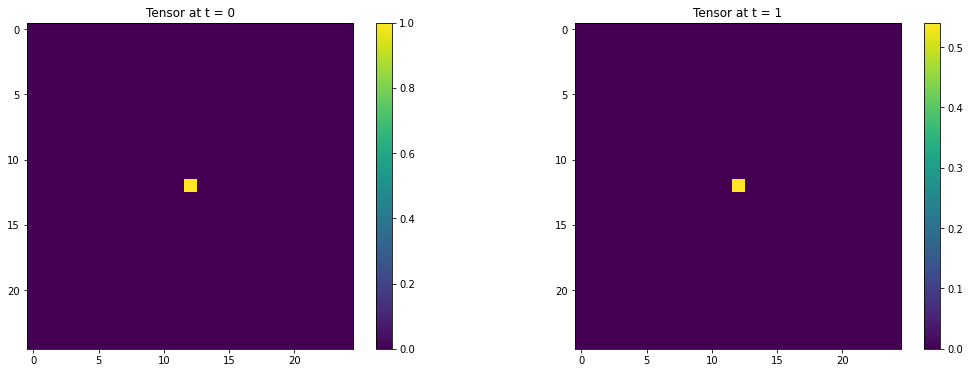

In [6]:
# Specify the size of the tensor
xysize = 25

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
mu_x = 0.5
mu_y = 0.5
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

# Plot the tensors
plt.figure(figsize=(18, 6))

# Plot at t = 0
plt.subplot(1, 2, 1)
plt.imshow(status_t0.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 0')
plt.colorbar()

# Plot at t = 1
plt.subplot(1, 2, 2)
plt.imshow(status_t1.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 1')
plt.colorbar()

# # Plot at t = 2
# plt.subplot(1, 3, 3)
# plt.imshow(status_t2.numpy(), cmap='viridis', interpolation='none')
# plt.title('Tensor at t = 2')
# plt.colorbar()

plt.show()

#### C spead of sound

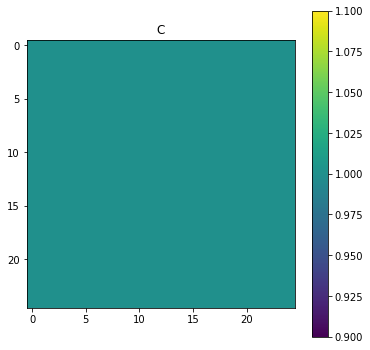

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [7]:
c_np = np.ones((xysize, xysize))

# uncomment to make the values different
# right_half_start = xysize // 2
# c_np[:, right_half_start:] = 2

c = torch.from_numpy(c_np).float().requires_grad_()

# Plot the tensor at t = 0
plt.figure(figsize=(6, 6))
plt.imshow(c.detach().numpy(), cmap='viridis', interpolation='none')
plt.title('C')
plt.colorbar()
plt.show()

c = c.to(device)
print(c)

#### Sigma2

In [8]:
l = xysize/10

In [9]:
value_origin_point = - 9 * (4-0)
k = 400

In [10]:
sigma2 = torch.zeros((xysize, xysize), dtype=torch.float32)

In [11]:
l_over_speed = (l / 1) * 0.05 
print(l_over_speed)

0.125


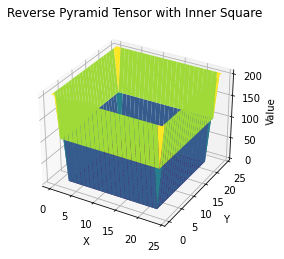

In [12]:
def create_reverse_pyramid_tensor(size, inner_square_ratio):
    pyramid = np.zeros((size, size), dtype=np.float32)

    center = size // 2
    center_value = -16.0/(l_over_speed*l_over_speed)
    boundary_value = 4.0/(l_over_speed*l_over_speed)

    inner_square_width = int(size * inner_square_ratio)

    for i in range(size):
        for j in range(size):
            distance_to_center = max(abs(i - center), abs(j - center))
            
            # Set the values for the reverse pyramid
            pyramid[i, j] = center_value + 4.0/(l_over_speed*l_over_speed) * (distance_to_center/xysize/0.1)
            
            # Set the values for the inner square to 0
            if (
                i >= center - inner_square_width // 2 and i < center + inner_square_width // 2
                and j >= center - inner_square_width // 2 and j < center + inner_square_width // 2
            ):
                pyramid[i, j] = 0.0

    return pyramid

# Set the size of the pyramid (choose an odd number for symmetry)
pyramid_size = 25  # xysize = 25
# inner_square_ratio = 9/10
inner_square_ratio = 4/5

# Create the reverse pyramid tensor with inner square values set to 0
sigma2 = create_reverse_pyramid_tensor(pyramid_size, inner_square_ratio)

# Plot the reverse pyramid tensor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(0, pyramid_size, 1)
y = np.arange(0, pyramid_size, 1)
x, y = np.meshgrid(x, y)

ax.plot_surface(x, y, sigma2, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')
ax.set_title('Reverse Pyramid Tensor with Inner Square')

plt.show()

sigma2 = torch.from_numpy(sigma2).to(device)

tensor([[204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000,
         204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000,
         204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000,
         204.8000, 204.8000, 204.8000, 204.8000],
        [204.8000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000,
         102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000,
         102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000,
         102.4000, 102.4000, 102.4000, 204.8000],
        [204.8000, 102.4000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000, 102.4000, 204.8000],
        [204.8000, 102.4000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

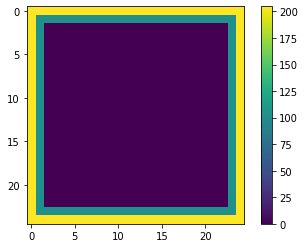

In [13]:
print(sigma2)
plt.imshow(sigma2.detach().cpu().numpy(), cmap='viridis', interpolation='none')
plt.colorbar()

#### ML

In [14]:
ML = torch.ones((1, 1, xysize, xysize), dtype=torch.float64)

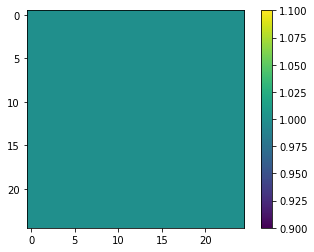

In [15]:
plt.imshow((ML/ML)[0][0].detach().cpu().numpy(), cmap='viridis', interpolation='none')
plt.colorbar()

### Define NN Model

#### one time step - skipping layers

In [16]:
# class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
#     def __init__(self, xysize, filter_weight):
#         super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

#         # Specify the size of the input (batch_size, channels, height, width)
#         in_channels = 1

#         # Specify the size of the filter/kernel
#         kernel_size = filter_weight.shape[2]
#         padding = (kernel_size - 1) // 2

#         # Create a Conv2d layer with the specified weight, input size, and padding
#         self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
#         self.conv_layer.weight.data = filter_weight

#         self.xysize = xysize

#     def forward(self, status_tn, status_tn_1, c_value, sigma2_inv):
#         output_list = [status_tn]

#         c = torch.ones((self.xysize, self.xysize), device=device)
        
#         for i in range(c_value.shape[0]):
#             for j in range(c_value.shape[0]):
#                 ones = torch.zeros((self.xysize, self.xysize), device=device)
#                 ones[i*int(self.xysize/c_value.shape[0]):(i+1)*int(self.xysize/c_value.shape[0]), j*int(self.xysize/c_value.shape[0]):(j+1)*int(self.xysize/c_value.shape[0])] = (i+j) % 2  # Alternate between 0 and 1
#                 c += ones * c_value[i]

#         # Calculate status_tn1 based on the provided expression
#         c_status_tn = c * status_tn
#         conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
        
#         status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
        
#         output_list.append(status_tn1)

#         output_stacked = torch.cat(output_list, dim=1)

#         return output_stacked

In [17]:
class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c, sigma2_inv):
        
        output_list = [status_tn]

        # Calculate status_tn1 based on the provided expression
        c_status_tn = c * status_tn
        conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
        
        status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
        
        output_list.append(status_tn1)

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

#### multi time step - skipping layers 10 C values

In [18]:
class ConstantCValueLayer(nn.Module):
    def __init__(self, xysize):
        super(ConstantCValueLayer, self).__init__()
        self.xysize = xysize

    def forward(self, c_value):
        c_value.retain_grad()
        c = torch.full((self.xysize, self.xysize), c_value.item(), device=device, requires_grad=True)
        return c

In [19]:
class AI4WaveNeuralNetwork_Multi_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_Multi_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.constant_layer = ConstantCValueLayer(xysize)

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c_value, sigma2_inv, nsteps):
        output_list = [status_tn_1, status_tn]

        c = torch.zeros((self.xysize, self.xysize), device=device)
        for i in range(c_value.shape[0]):
            ones = torch.zeros((self.xysize, self.xysize), device=device)
            ones[i*int(self.xysize/c_value.shape[0]):(i+1)*int(self.xysize/c_value.shape[0])] = 1
            c += ones * c_value[i]

        for i in range(nsteps):
            # Calculate status_tn1 based on the provided expression
            c_status_tn = c * status_tn
            conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
            
            status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
            
            output_list.append(status_tn1)

            status_tn_1 = status_tn
            status_tn = status_tn1

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

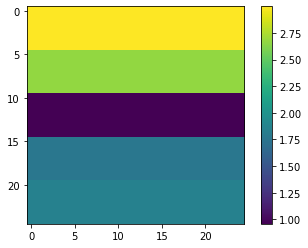

In [20]:
a = 0.5  # lower bound
b = 3  # upper bound
vec = a + (b - a) * torch.rand(5, requires_grad=True, dtype=torch.float64, device=device)

c = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)

for i in range(5):
    ones = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)
    ones[i*5:(i+1)*5] = 1
    c += ones * vec[i]


plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

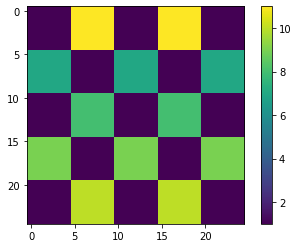

In [21]:
a = 0.5  # lower bound
b = 3  # upper bound
# vec = a + (b - a) * torch.rand(5, requires_grad=True, dtype=torch.float64, device=device)
vec = [10, 6, 7, 8, 9]

c = torch.ones((25, 25), device='cuda:0', dtype=torch.float64)

for i in range(5):
    for j in range(5):
        ones = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)
        ones[i*5:(i+1)*5, j*5:(j+1)*5] = (i+j) % 2  # Alternate between 0 and 1
        c += ones * vec[i]

plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

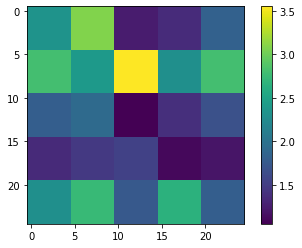

In [22]:
torch.manual_seed(0)  # Set the seed

a = 0.5  # lower bound
b = 3  # upper bound
vec = a + (b - a) * torch.rand(5, requires_grad=True, dtype=torch.float64, device=device)

c = torch.ones((25, 25), device='cuda:0', dtype=torch.float64)

for i in range(5):
    for j in range(5):
        ones = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)
        ones[i*5:(i+1)*5, j*5:(j+1)*5] = torch.rand(1).item()  # Assign a random value
        c += ones * vec[i]

plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

### Define functions to form C values

#### Checkerboard

In [23]:
def create_simple_checkerboard(c_values_tensor):
    c = torch.ones((xysize, xysize), device=device)
        
    for i in range(c_values_tensor.shape[0]):
        for j in range(c_values_tensor.shape[0]):
            ones = torch.zeros((xysize, xysize), device=device)
            ones[i*int(xysize/c_values_tensor.shape[0]):(i+1)*int(xysize/c_values_tensor.shape[0]), j*int(xysize/c_values_tensor.shape[0]):(j+1)*int(xysize/c_values_tensor.shape[0])] = (i+j) % 2  # Alternate between 0 and 1
            c += ones * c_values_tensor[i]
    
    return c

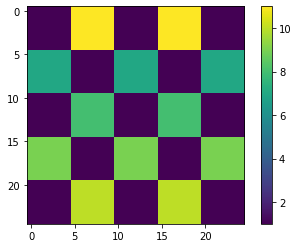

In [24]:
C_tensors_list = [10, 6, 7, 8, 9]
c_tensor = torch.tensor(C_tensors_list, dtype=torch.float32, device=device, requires_grad=True)
c = create_simple_checkerboard(c_tensor)
plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

tensor([5., 7., 5., 5., 6., 1., 9., 3., 3., 4., 6., 2., 5., 6., 9., 7., 5., 6.,
        6., 5., 4., 7., 9., 2., 9.], device='cuda:0', requires_grad=True)


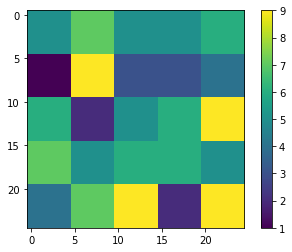

In [25]:
# number_rows = 5
# number_cols = 5
# number_all = number_rows * number_cols

# torch.manual_seed(0)  # Set the seed for reproducibility

# # c_values_tensor = torch.rand(number_all, dtype=torch.float32, device=device, requires_grad=True)
# c_values_tensor = torch.randint(low=0, high=10, size=(number_all,), device=device, dtype=torch.int)
# print(c_values_tensor)

# c = torch.zeros((xysize, xysize), device=device)  # Initialize c with zeros

# for i in range(number_rows):
#     for j in range(number_cols):
#         ones = torch.zeros((xysize, xysize), device=device)
#         ones[i*int(xysize/number_rows):(i+1)*int(xysize/number_rows), j*int(xysize/number_cols):(j+1)*int(xysize/number_cols)] = c_values_tensor[i*number_rows + j]
#         c += ones


number_rows = 5
number_cols = 5
number_all = number_rows * number_cols
torch.manual_seed(0)
c_values_tensor = torch.randint(low=1, high=10, size=(number_all,), device=device, dtype=torch.float32, requires_grad=True)

print(c_values_tensor)

def create_checkerboard(c_values_tensor, xsize, ysize, number_rows, number_cols):
    

    c = torch.zeros((xsize, ysize), device=device)  # Initialize c with zeros

    for i in range(number_rows):
        for j in range(number_cols):
            ones = torch.zeros((xsize, ysize), device=device)
            ones[i*int(xsize/number_rows):(i+1)*int(xsize/number_rows), j*int(ysize/number_cols):(j+1)*int(ysize/number_cols)] = c_values_tensor[i*number_rows + j]
            c += ones

    return c

c = create_checkerboard(c_values_tensor, xysize, xysize, number_rows, number_cols)

plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()



#### Real Data

In [26]:
# Path to the .npy file
file_path = "/home/dg321/gitTest/PRI/irp/AI4Multiphase/Data_Haifa/velocity.npy"

# Load the data
data = np.load(file_path)

print(data.shape)

(3001, 2194)


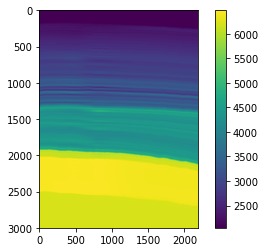

In [27]:
plt.imshow(data)
plt.colorbar()

In [28]:
xysize = 80

In [29]:
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

# Resize the data
resized_data = resize(data, (xysize, xysize))

# Scale the values between 5 and 15
scaler = MinMaxScaler(feature_range=(5, 15))
scaled_data = scaler.fit_transform(resized_data.reshape(-1, 1))

# Reshape the data back to the original shape
scaled_data = scaled_data.reshape(xysize, xysize)

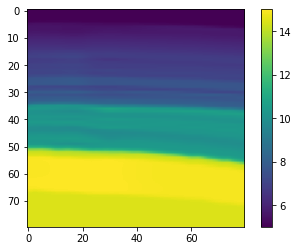

In [30]:
plt.imshow(scaled_data)
plt.colorbar()

In [31]:
def create_c_field(requires_grad):
    c = torch.tensor(scaled_data, device=device, dtype=torch.float32, requires_grad=requires_grad)
    return c

In [32]:
def create_c_field_likereal(initial_value, requires_grad):
    scaled_data_tensor = torch.tensor(scaled_data, device=device, dtype=torch.float32)
    c = initial_value * torch.ones_like(scaled_data_tensor, device=device, dtype=torch.float32, requires_grad=requires_grad)
    return c

### Data assimilation one timestep - skipping layers

#### Generate Obs

##### create initial step

In [118]:
# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    # assert len(mu_x) == len(mu_y), "mu_x and mu_y must have the same length"
    result = torch.zeros_like(x)
    for mx, my in zip(mu_x, mu_y):
        exponent = -((x - mx)**2 / (2 * sigma_x**2) + (y - my)**2 / (2 * sigma_y**2))
        gauss = torch.exp(exponent)
        result += gauss / gauss.max()
    return result

# Parameters for Gaussian distributions
sigma_x = 0.005
sigma_y = 0.005

# Define the mu_x and mu_y values for the five points
mu_x = [0.10, 0.25, 0.5, 0.75, 0.90, 0.10, 0.25, 0.5, 0.75, 0.90, 0.10, 0.25, 0.5, 0.75, 0.90]
mu_y = [0.95, 0.95, 0.95, 0.95, 0.95, 0.65, 0.65, 0.65, 0.65, 0.65, 0.35, 0.35, 0.35, 0.35, 0.35]

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

In [48]:
# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    # assert len(mu_x) == len(mu_y), "mu_x and mu_y must have the same length"
    result = torch.zeros_like(x)
    for mx, my in zip(mu_x, mu_y):
        exponent = -((x - mx)**2 / (2 * sigma_x**2) + (y - my)**2 / (2 * sigma_y**2))
        result += torch.exp(exponent)
    return result

# Parameters for Gaussian distributions
sigma_x = 0.005
sigma_y = 0.005

# # Define the mu_x and mu_y values for the four points
# mu_x = [0.25, 0.75, 0.25, 0.75]
# mu_y = [0.25, 0.25, 0.75, 0.75]

# # Evaluate the Gaussian distributions at t = 0, 1, and 2
# t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
# t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Define the mu_x and mu_y values for the eight points
mu_x = [0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.125, 0.875]
mu_y = [0.25, 0.25, 0.75, 0.75, 0.125, 0.875, 0.5, 0.5]

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

In [60]:
# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    assert len(mu_x) == len(mu_y) == len(sigma_x) == len(sigma_y), "All input lists must have the same length"
    result = torch.zeros_like(x)
    for mx, my, sx, sy in zip(mu_x, mu_y, sigma_x, sigma_y):
        exponent = -((x - mx)**2 / (2 * sx**2) + (y - my)**2 / (2 * sy**2))
        result += torch.exp(exponent)
    return result

# Define the mu_x, mu_y, sigma_x, and sigma_y values for the eight points
mu_x = [0.25, 0.75, 0.25, 0.75, 0.5]
mu_y = [0.25, 0.25, 0.75, 0.75, 0.125]
sigma_x = [0.005, 0.005, 0.005, 0.005, 0.005]
sigma_y = [0.005, 0.005, 0.005, 0.005, 0.005]

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

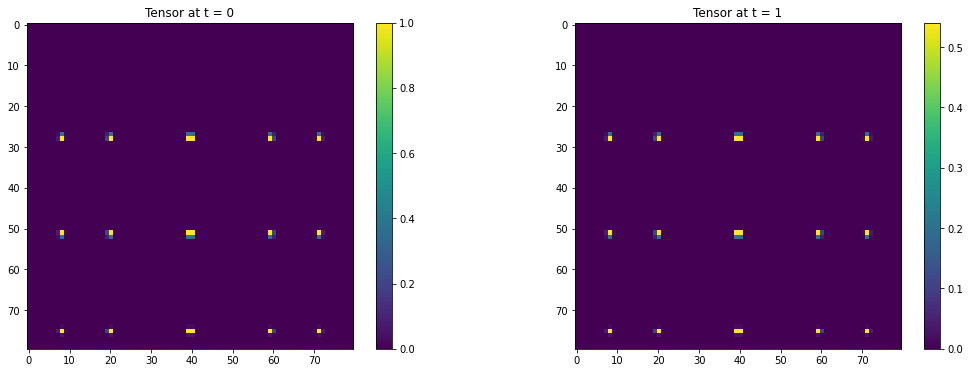

In [119]:
# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

# Plot the tensors
plt.figure(figsize=(18, 6))

# Plot at t = 0
plt.subplot(1, 2, 1)
plt.imshow(status_t0.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 0')
plt.colorbar()

# Plot at t = 1
plt.subplot(1, 2, 2)
plt.imshow(status_t1.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 1')
plt.colorbar()

# # Plot at t = 2
# plt.subplot(1, 3, 3)
# plt.imshow(status_t2.numpy(), cmap='viridis', interpolation='none')
# plt.title('Tensor at t = 2')
# plt.colorbar()

plt.show()

In [34]:
## Using bigger model - multi time steps
# # Specify the size of the tensor
# xysize = 125
# mu_x = 0.2   # 0.5
# mu_y = 0.2  # 0.5

# timesteps = 10    # 300

# # C values
# C_values_list = [5, 6, 7, 8, 9]
# # C_values_list = [1, 1, 1, 1, 1]
# c_tensor = torch.tensor(C_values_list, dtype=torch.float32, device=device, requires_grad=True)

# nlayers = c_tensor.size(0)

# # Plot C
# c = torch.zeros((xysize, xysize), device=device, dtype=torch.float32)

# for i in range(nlayers):
#     ones = torch.zeros((xysize, xysize), device=device, dtype=torch.float32)
#     ones[i*int(xysize/nlayers):(i+1)*int(xysize/nlayers)] = 1
#     c += ones * c_tensor[i]

# plt.imshow(c.cpu().detach().numpy(), cmap='viridis')
# plt.colorbar()
# plt.title('C Values - Ground Truth')
# plt.show()

# # Create a meshgrid
# x_values = np.linspace(0, 1, xysize)
# y_values = np.linspace(0, 1, xysize)
# x, y = np.meshgrid(x_values, y_values)

# # Convert NumPy arrays to PyTorch tensors with float type
# x_tensor = torch.tensor(x, dtype=torch.float32)
# y_tensor = torch.tensor(y, dtype=torch.float32)

# # Equation parameters
# sqrt2 = np.sqrt(2)
# pi = np.pi

# # Define the time tensors for t = 0, 1, and 2
# time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
# time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# # Function to create 2D Gaussian distribution
# def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
#     exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
#     return torch.exp(exponent)

# # Parameters for Gaussian distributions
# sigma_x = 0.005
# sigma_y = 0.005

# # Evaluate the Gaussian distributions at t = 0, 1, and 2
# t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
# t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# # Stack the tensors along a new dimension to create 3D tensors
# status_t0 = t0_values
# status_t1 = t1_values

# filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter

# mymodel_multi = AI4WaveNeuralNetwork_Multi_Skipping(xysize, filter_weight)

# status_t0_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

# # Perform a forward pass using AI4WaveNeuralNetwork
# status_t1_tensor = status_t1.view(1, 1, xysize, xysize).to(device)

# # Initial Status (t = 0)
# fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# # Plot the image on the first subplot
# im = axs[0].imshow(status_t0.cpu().detach().numpy(), cmap='viridis')
# fig.colorbar(im, ax=axs[0])
# axs[0].set_title("Initial Status (t = 0)")

# # Plot the vertical profile on the second subplot
# vertical_profile = status_t0.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
# axs[1].plot(vertical_profile)
# axs[1].set_title("Vertical profile at t = 0")

# plt.show()

# # Initial Status (t = 1)
# fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# # Plot the image on the first subplot
# im = axs[0].imshow(status_t1.cpu().detach().numpy(), cmap='viridis')
# fig.colorbar(im, ax=axs[0])
# axs[0].set_title("Initial Status (t = 1)")

# # Plot the vertical profile on the second subplot
# vertical_profile = status_t1.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
# axs[1].plot(vertical_profile)
# axs[1].set_title("Vertical profile at t = 1")

# plt.show()

# output_tensor_obs = mymodel_multi(status_t1_tensor, status_t0_tensor, c_tensor, sigma2, nsteps = timesteps)

# for i in range(timesteps):
#     if (i) % 5 == 0:
#         fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

#         # Plot the image on the first subplot
#         im = axs[0].imshow(output_tensor_obs.cpu().detach().numpy()[0][i+2], cmap='viridis')
#         fig.colorbar(im, ax=axs[0])
#         axs[0].set_title(f"Status at t = {i+2}")

#         # Plot the vertical profile on the second subplot
#         vertical_profile = output_tensor_obs.cpu().detach().numpy()[0][i+2][xysize//2, :]  # Take the middle row
#         axs[1].plot(vertical_profile)
#         axs[1].set_title(f"Vertical profile at t = {i+2}")

#         plt.show()

# print(output_tensor_obs.shape)

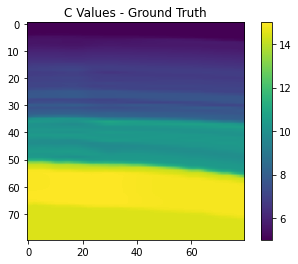

torch.Size([42, 80, 80])


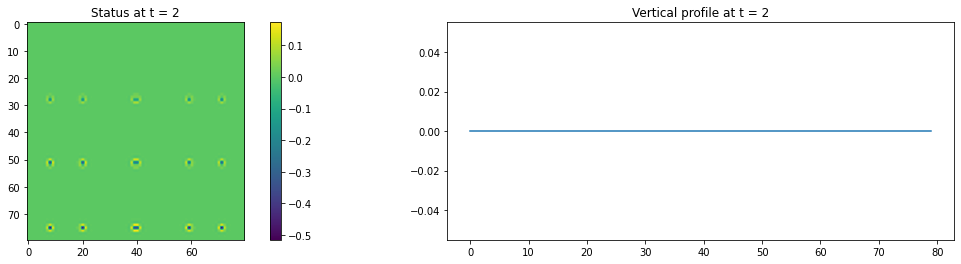

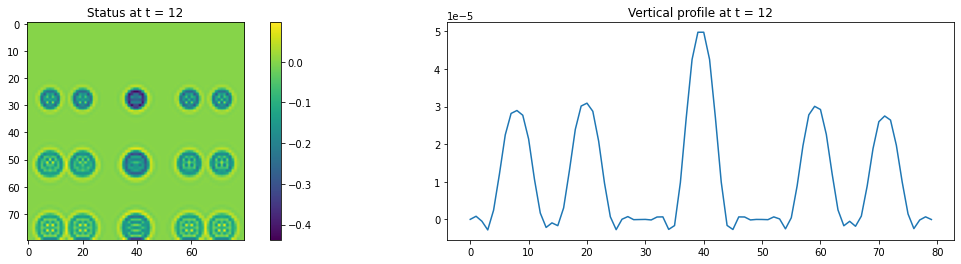

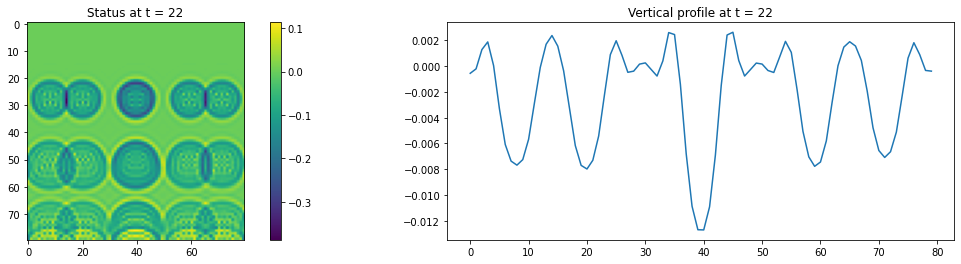

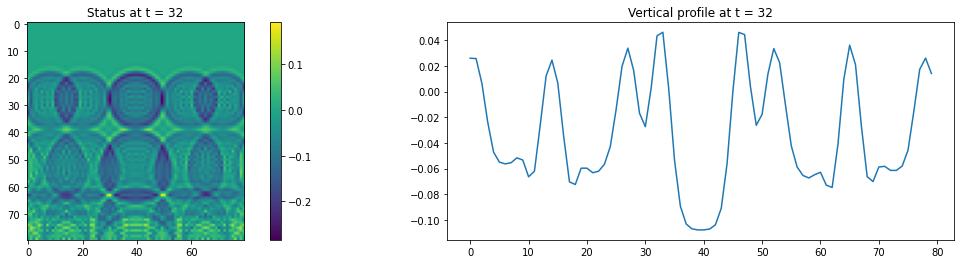

torch.Size([42, 80, 80])


In [120]:
timesteps = 40

# Specify the size of the tensor
mu_x = 0.5   # 0.5
mu_y = 0.5  # 0.5

# # C values
# C_tensors_list = [10, 6, 7, 8, 9]
# # C_tensors_list = [1, 1, 1, 1, 1]
# c_tensor = torch.tensor(C_tensors_list, dtype=torch.float32, device=device, requires_grad=True)

# nlayers = c_tensor.size(0)

# # Plot C
# c = torch.ones((xysize, xysize), device=device, dtype=torch.float32)

# for i in range(nlayers):
#     for j in range(nlayers):
#         ones = torch.zeros((xysize, xysize), device=device, dtype=torch.float32)
#         ones[i*int(xysize/c_tensor.shape[0]):(i+1)*int(xysize/c_tensor.shape[0]), j*int(xysize/c_tensor.shape[0]):(j+1)*int(xysize/c_tensor.shape[0])] = (i+j) % 2  # Alternate between 0 and 1
#         c += ones * c_tensor[i]  # Use both i and j to index c_tensor

# plt.imshow(c.cpu().detach().numpy(), cmap='viridis')
# plt.colorbar()
# plt.title('C Values - Ground Truth')
# plt.show()

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
# def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
#     exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
#     return torch.exp(exponent)

# Parameters for Gaussian distributions
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
# t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
# t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)
# t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
# t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

status_t0_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

status_t1_tensor = status_t1.view(1, 1, xysize, xysize).to(device)

filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter

# Define a single model
mymodel_obs = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight).to(device)


# Forward pass through the model
output_list = [status_t0_tensor, status_t1_tensor]
input1 = status_t1_tensor
input2 = status_t0_tensor


number_rows = 5
number_cols = 5
number_all = number_rows * number_cols
torch.manual_seed(0)

# c_values_tensor_obs = torch.randint(low=1, high=10, size=(number_all,), device=device, dtype=torch.float32, requires_grad=True)
# c = create_checkerboard(c_values_tensor_obs, xysize, xysize, number_rows, number_cols)

c = create_c_field(requires_grad=False)
# c = create_c_field_likereal(1, requires_grad=False)

c_show = c
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Ground Truth')
plt.show()

for _ in range(timesteps):
    output = mymodel_obs(input1, input2, c, sigma2)
    output_list.append(output[:,1:, :, :])
    input1 = output[:,1:, :, :]
    input2 = output[:,0:1, :, :]

# Concatenate the output list along the time dimension
output_tensor_obs = torch.cat(output_list, dim=1).squeeze(0)

print(output_tensor_obs.shape)

for i in range(timesteps):
    if (i) % 10 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

        # Plot the image on the first subplot
        im = axs[0].imshow(output_tensor_obs.cpu().detach().numpy()[i+2], cmap='viridis')
        fig.colorbar(im, ax=axs[0])
        axs[0].set_title(f"Status at t = {i+2}")

        # Plot the vertical profile on the second subplot
        vertical_profile = output_tensor_obs.cpu().detach().numpy()[i+2][xysize//2, :]  # Take the middle row
        axs[1].plot(vertical_profile)
        axs[1].set_title(f"Vertical profile at t = {i+2}")

        plt.show()

print(output_tensor_obs.shape)

In [121]:
Status_List_stacked_obs = output_tensor_obs.squeeze(0)
print(Status_List_stacked_obs.shape)

torch.Size([42, 80, 80])


#### One time forward stepping

[[ 0  0]
 [ 0  1]
 [ 0  2]
 ...
 [79 77]
 [79 78]
 [79 79]]


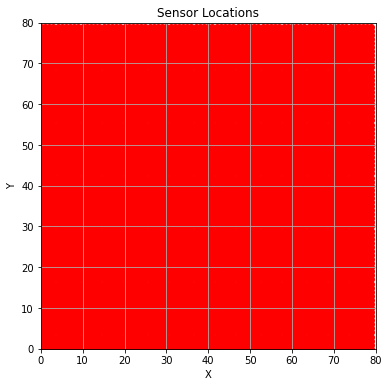

In [122]:
# Set the seed for reproducibility
np.random.seed(0)

# Define the size of your domain
domain_size = (xysize, xysize)  # Example: xysizexxysize grid

n_srata = xysize    #  5
n_sensors = n_srata * n_srata

# Define the number of strata in each dimension
strata_size = (n_srata, n_srata)  # Example: 10x10 strata

# Calculate the size of each stratum
stratum_size = (domain_size[0] // strata_size[0], domain_size[1] // strata_size[1])

# Generate random sensor locations within each stratum
sensor_indices = np.array([
    (np.random.randint(i * stratum_size[0], (i + 1) * stratum_size[0]),
     np.random.randint(j * stratum_size[1], (j + 1) * stratum_size[1]))
    for i in range(strata_size[0])
    for j in range(strata_size[1])
])

# Plot the domain
plt.figure(figsize=(6, 6))
plt.xlim(0, domain_size[0])
plt.ylim(0, domain_size[1])

print(sensor_indices)

# Plot the sensor locations
plt.scatter(sensor_indices[:, 0], sensor_indices[:, 1], color='red')

plt.title('Sensor Locations')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [123]:
# Convert sensor_indices to a PyTorch tensor
sensor_indices = torch.tensor(sensor_indices)

# Separate the x and y coordinates
x_coords = sensor_indices[:, 0]
y_coords = sensor_indices[:, 1]

# Use broadcasting to create a grid of indices
x_coords = x_coords[None, :, None]
y_coords = y_coords[None, :, None]

# Index the output and observation tensors at the sensor locations
# output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
# obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

# Now, output_at_sensors and obs_at_sensors should have the shape (302, 25)
# print(output_at_sensors.shape)
# print(obs_at_sensors.shape)

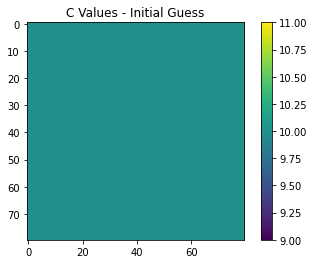

loss,█▇▇▆▆▆▅▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1e-05


2024-05-08 20:38:22.496483: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


epochs: 0


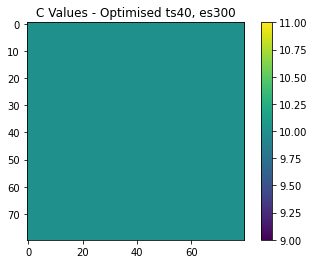

epochs: 100


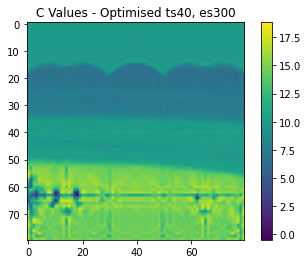

epochs: 200


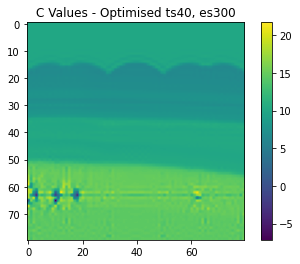

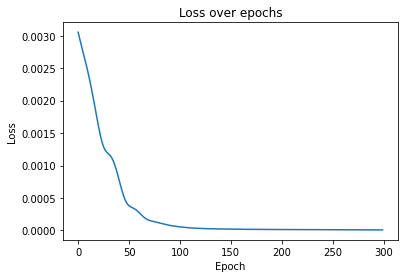

In [124]:
mse_loss = nn.MSELoss()

number_rows = 80   #40
number_cols = 80   #40
number_all = number_rows * number_cols

# C guess
C_guess_value = 10
# c_forward1 = torch.tensor([C_guess_value]*number_all, dtype=torch.float32, device=device, requires_grad=True)

c_forward1 = create_c_field_likereal(C_guess_value, requires_grad=False).detach().requires_grad_(True)

# c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
c_show = create_c_field_likereal(C_guess_value, requires_grad=True)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Initial Guess')
plt.show()

# lr = 0.1
lr = 0.1

name = " Real Data, guess {}s, number_rows{}, number_cols{}, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(C_guess_value, number_rows, number_cols, timesteps, xysize, xysize, lr, n_sensors, mu_x, mu_y)

# Start a new run
run = wandb.init(project="wave eqn - checkerboard", name = " Real Data, guess {}s, number_rows{}, number_cols{}, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(C_guess_value, number_rows, number_cols, timesteps, xysize, xysize, lr, n_sensors, mu_x, mu_y))

# Use Adam optimizer
optimizer = torch.optim.Adam([c_forward1], lr)
c_values = [c_forward1.tolist()]

losses = []
epochs = 300

# Move clone operation outside the loop
Obs_sensor_3d_array = Status_List_stacked_obs.clone()

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

for n in range(epochs):
    if n % 100 == 0:  # Print every 100 epochs
        print('epochs:', n)
        c_show = c_forward1
        plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
        plt.colorbar()
        plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
        plt.show()
    optimizer.zero_grad()
    # Forward pass through the model
    output_list = [status_t0_tensor, status_t1_tensor]
    input1 = status_t1_tensor
    input2 = status_t0_tensor

    # c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
    c = c_forward1

    for _ in range(timesteps):
        output = model(input1, input2, c, sigma2)
        output_list.append(output[:,1:, :, :])
        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]

    # Concatenate the output list along the time dimension
    output_tensor = torch.cat(output_list, dim=1).squeeze(0)

    # # Compute the loss
    # loss = mse_loss(output_tensor, Obs_sensor_3d_array)

    # Index the output tensor at the sensor locations
    # print(output_tensor.shape)
    # output_at_sensors = output_tensor[:, sensor_indices]
    # print(output_at_sensors.shape)

    # # Index the observation tensor at the sensor locations
    # obs_at_sensors = Obs_sensor_3d_array[:, sensor_indices]

    # Index the output and observation tensors at the sensor locations
    output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
    obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

    # Compute the loss
    loss = mse_loss(output_at_sensors, obs_at_sensors)

    # Backward pass to calculate gradients
    loss.backward(retain_graph=True)

    losses.append(loss.item())

    # optimize C
    optimizer.step()
    c_values.append(c_forward1.tolist())

    # Log the loss and c_value to wandb
    log_dict = {"loss": loss.item()}
    log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward1.tolist())})
    wandb.log(log_dict)

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plt.figure()
# plt.plot(c_values)
# plt.title('c_values over epochs')
# plt.xlabel('Epoch')
# plt.ylabel('c_value')
# plt.show()

epochs: 0


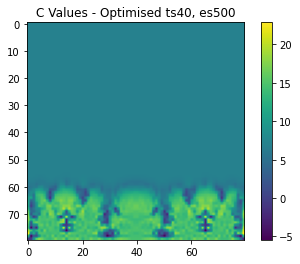

epochs: 100


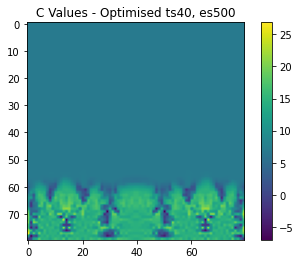

epochs: 200


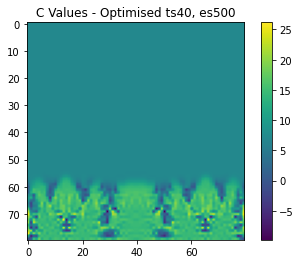

epochs: 300


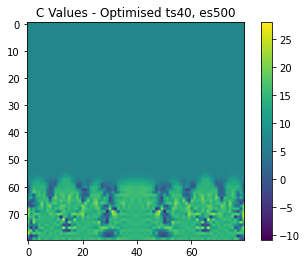

epochs: 400


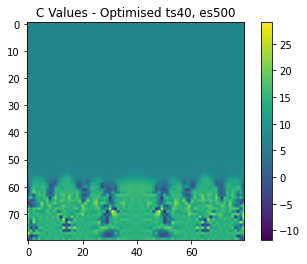

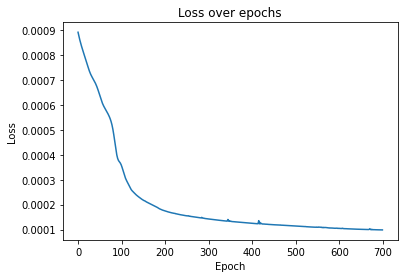

In [101]:
epochs = 500

# Move clone operation outside the loop
Obs_sensor_3d_array = Status_List_stacked_obs.clone()

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

for n in range(epochs):
    if n % 100 == 0:  # Print every 100 epochs
        print('epochs:', n)
        c_show = c_forward1
        plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
        plt.colorbar()
        plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
        plt.show()
    optimizer.zero_grad()
    # Forward pass through the model
    output_list = [status_t0_tensor, status_t1_tensor]
    input1 = status_t1_tensor
    input2 = status_t0_tensor

    # c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
    c = c_forward1

    for _ in range(timesteps):
        output = model(input1, input2, c, sigma2)
        output_list.append(output[:,1:, :, :])
        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]

    # Concatenate the output list along the time dimension
    output_tensor = torch.cat(output_list, dim=1).squeeze(0)

    # # Compute the loss
    # loss = mse_loss(output_tensor, Obs_sensor_3d_array)

    # Index the output tensor at the sensor locations
    # print(output_tensor.shape)
    # output_at_sensors = output_tensor[:, sensor_indices]
    # print(output_at_sensors.shape)

    # # Index the observation tensor at the sensor locations
    # obs_at_sensors = Obs_sensor_3d_array[:, sensor_indices]

    # Index the output and observation tensors at the sensor locations
    output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
    obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

    # Compute the loss
    loss = mse_loss(output_at_sensors, obs_at_sensors)

    # Backward pass to calculate gradients
    loss.backward(retain_graph=True)

    losses.append(loss.item())

    # optimize C
    optimizer.step()
    c_values.append(c_forward1.tolist())

    # Log the loss and c_value to wandb
    log_dict = {"loss": loss.item()}
    log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward1.tolist())})
    wandb.log(log_dict)

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plt.figure()
# plt.plot(c_values)
# plt.title('c_values over epochs')
# plt.xlabel('Epoch')
# plt.ylabel('c_value')
# plt.show()

epochs: 0


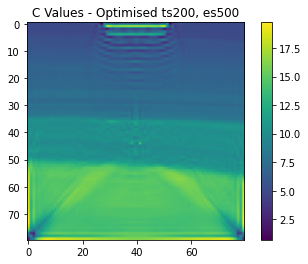

epochs: 100


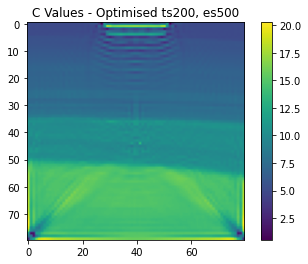

epochs: 200


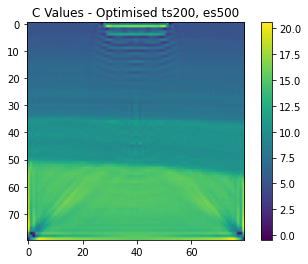

epochs: 300


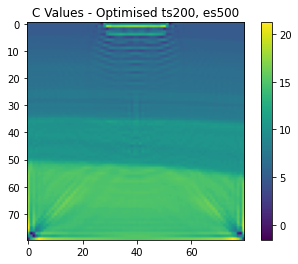

epochs: 400


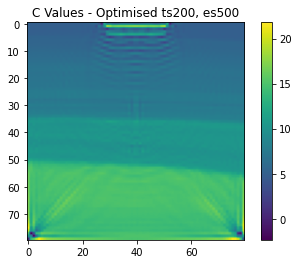

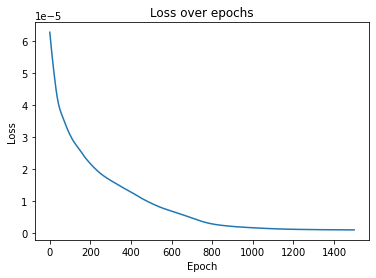

In [71]:
epochs = 500

# Move clone operation outside the loop
Obs_sensor_3d_array = Status_List_stacked_obs.clone()

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

for n in range(epochs):
    if n % 100 == 0:  # Print every 100 epochs
        print('epochs:', n)
        c_show = c_forward1
        plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
        plt.colorbar()
        plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
        plt.show()
    optimizer.zero_grad()
    # Forward pass through the model
    output_list = [status_t0_tensor, status_t1_tensor]
    input1 = status_t1_tensor
    input2 = status_t0_tensor

    # c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
    c = c_forward1

    for _ in range(timesteps):
        output = model(input1, input2, c, sigma2)
        output_list.append(output[:,1:, :, :])
        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]

    # Concatenate the output list along the time dimension
    output_tensor = torch.cat(output_list, dim=1).squeeze(0)

    # # Compute the loss
    # loss = mse_loss(output_tensor, Obs_sensor_3d_array)

    # Index the output tensor at the sensor locations
    # print(output_tensor.shape)
    # output_at_sensors = output_tensor[:, sensor_indices]
    # print(output_at_sensors.shape)

    # # Index the observation tensor at the sensor locations
    # obs_at_sensors = Obs_sensor_3d_array[:, sensor_indices]

    # Index the output and observation tensors at the sensor locations
    output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
    obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

    # Compute the loss
    loss = mse_loss(output_at_sensors, obs_at_sensors)

    # Backward pass to calculate gradients
    loss.backward(retain_graph=True)

    losses.append(loss.item())

    # optimize C
    optimizer.step()
    c_values.append(c_forward1.tolist())

    # Log the loss and c_value to wandb
    log_dict = {"loss": loss.item()}
    log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward1.tolist())})
    wandb.log(log_dict)

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plt.figure()
# plt.plot(c_values)
# plt.title('c_values over epochs')
# plt.xlabel('Epoch')
# plt.ylabel('c_value')
# plt.show()

epochs: 0


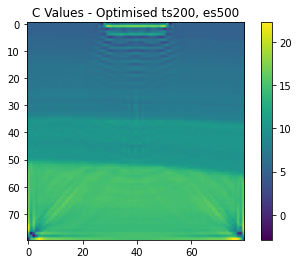

epochs: 100


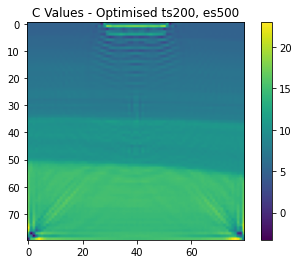

epochs: 200


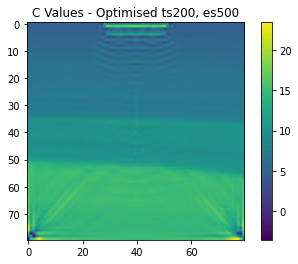

epochs: 300


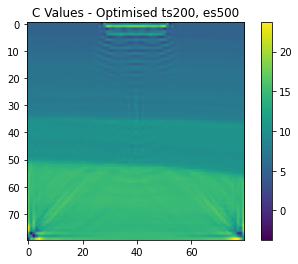

epochs: 400


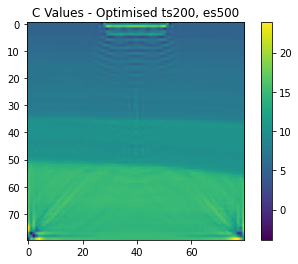

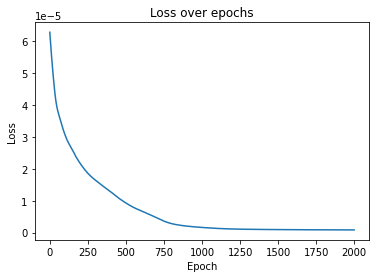

In [72]:
epochs = 500

# Move clone operation outside the loop
Obs_sensor_3d_array = Status_List_stacked_obs.clone()

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

for n in range(epochs):
    if n % 100 == 0:  # Print every 100 epochs
        print('epochs:', n)
        c_show = c_forward1
        plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
        plt.colorbar()
        plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
        plt.show()
    optimizer.zero_grad()
    # Forward pass through the model
    output_list = [status_t0_tensor, status_t1_tensor]
    input1 = status_t1_tensor
    input2 = status_t0_tensor

    # c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
    c = c_forward1

    for _ in range(timesteps):
        output = model(input1, input2, c, sigma2)
        output_list.append(output[:,1:, :, :])
        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]

    # Concatenate the output list along the time dimension
    output_tensor = torch.cat(output_list, dim=1).squeeze(0)

    # # Compute the loss
    # loss = mse_loss(output_tensor, Obs_sensor_3d_array)

    # Index the output tensor at the sensor locations
    # print(output_tensor.shape)
    # output_at_sensors = output_tensor[:, sensor_indices]
    # print(output_at_sensors.shape)

    # # Index the observation tensor at the sensor locations
    # obs_at_sensors = Obs_sensor_3d_array[:, sensor_indices]

    # Index the output and observation tensors at the sensor locations
    output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
    obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

    # Compute the loss
    loss = mse_loss(output_at_sensors, obs_at_sensors)

    # Backward pass to calculate gradients
    loss.backward(retain_graph=True)

    losses.append(loss.item())

    # optimize C
    optimizer.step()
    c_values.append(c_forward1.tolist())

    # Log the loss and c_value to wandb
    log_dict = {"loss": loss.item()}
    log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward1.tolist())})
    wandb.log(log_dict)

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plt.figure()
# plt.plot(c_values)
# plt.title('c_values over epochs')
# plt.xlabel('Epoch')
# plt.ylabel('c_value')
# plt.show()

In [60]:
print(len(c_values[-1]))

80


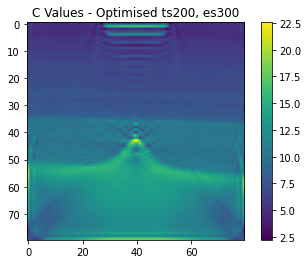

In [69]:
c_show = c_forward1
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[[6.001219749450684, 5.7950663566589355, 5.304692268371582, 5.013425350189209, 5.763319492340088, 5.624466896057129, 5.407559394836426, 5.007043361663818, 4.57683801651001, 4.232790470123291, 3.934924602508545, 3.76442289352417, 3.6958096027374268, 3.7029852867126465, 3.750882863998413, 3.893850803375244, 4.066375732421875, 4.287981986999512, 4.450129985809326, 4.549898624420166, 4.5450897216796875, 4.445462226867676, 4.1952595710754395, 3.871894359588623, 3.8214056491851807, 4.029171943664551, 4.44780158996582, 4.94978666305542, 5.269536018371582, 5.360352993011475, 5.308042049407959, 5.199611186981201, 5.080993175506592, 4.984462261199951, 4.928865909576416, 4.8994221687316895, 4.88314962387085, 4.878942966461182, 4.874863147735596, 4.864790916442871, 4.858452796936035, 4.862146854400635, 4.872350215911865, 4.886078834533691, 4.908566951751709, 4.945867538452148, 5.00180721282959, 5.082746982574463, 5.184618949890137, 5.28557825088501, 5.339886665344238, 5.2592267990112305, 4.9513974

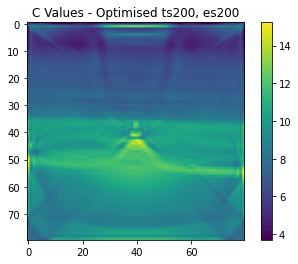

In [67]:
print(c_values[-1])
print(name)

c_show = c_forward1
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

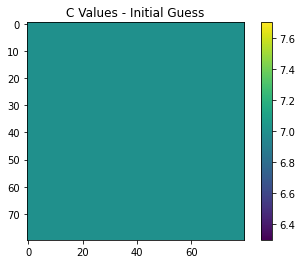

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guodh5 (guodh). Use `wandb login --relogin` to force relogin
2024-05-08 10:35:23.793485: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


epochs: 0
epochs: 100
epochs: 200
epochs: 300
epochs: 400
epochs: 500
epochs: 600
epochs: 700


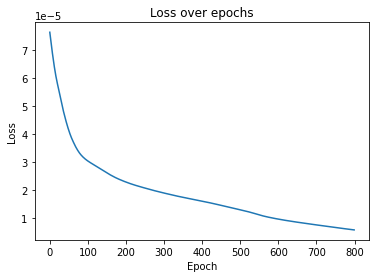

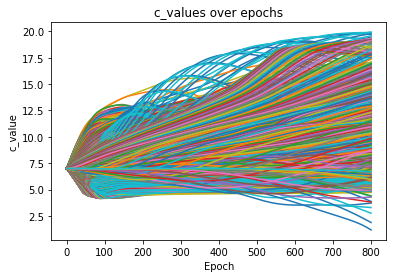

In [37]:
# mse_loss = nn.MSELoss()

# number_rows = 80   #40
# number_cols = 80   #40
# number_all = number_rows * number_cols

# # C guess
# C_guess_value = 7
# c_forward1 = torch.tensor([C_guess_value]*number_all, dtype=torch.float32, device=device, requires_grad=True)

# c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
# plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
# plt.colorbar()
# plt.title('C Values - Initial Guess')
# plt.show()

# # lr = 0.1
# lr = 0.1

# name = " Real Data, guess {}s, number_rows{}, number_cols{}, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(C_guess_value, number_rows, number_cols, timesteps, xysize, xysize, lr, n_sensors, mu_x, mu_y)

# # Start a new run
# run = wandb.init(project="wave eqn - checkerboard", name = " Real Data, guess {}s, number_rows{}, number_cols{}, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(C_guess_value, number_rows, number_cols, timesteps, xysize, xysize, lr, n_sensors, mu_x, mu_y))

# # Use Adam optimizer
# optimizer = torch.optim.Adam([c_forward1], lr)
# c_values = [c_forward1.tolist()]

# losses = []
# epochs = 800

# # Move clone operation outside the loop
# Obs_sensor_3d_array = Status_List_stacked_obs.clone()

# # Define a single model
# model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

# for n in range(epochs):
#     if n % 100 == 0:  # Print every 100 epochs
#         print('epochs:', n)
#     optimizer.zero_grad()
#     # Forward pass through the model
#     output_list = [status_t0_tensor, status_t1_tensor]
#     input1 = status_t1_tensor
#     input2 = status_t0_tensor

#     c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)

#     for _ in range(timesteps):
#         output = model(input1, input2, c, sigma2)
#         output_list.append(output[:,1:, :, :])
#         input1 = output[:,1:, :, :]
#         input2 = output[:,0:1, :, :]

#     # Concatenate the output list along the time dimension
#     output_tensor = torch.cat(output_list, dim=1).squeeze(0)

#     # # Compute the loss
#     # loss = mse_loss(output_tensor, Obs_sensor_3d_array)

#     # Index the output tensor at the sensor locations
#     # print(output_tensor.shape)
#     # output_at_sensors = output_tensor[:, sensor_indices]
#     # print(output_at_sensors.shape)

#     # # Index the observation tensor at the sensor locations
#     # obs_at_sensors = Obs_sensor_3d_array[:, sensor_indices]

#     # Index the output and observation tensors at the sensor locations
#     output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
#     obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

#     # Compute the loss
#     loss = mse_loss(output_at_sensors, obs_at_sensors)

#     # Backward pass to calculate gradients
#     loss.backward(retain_graph=True)

#     losses.append(loss.item())

#     # optimize C
#     optimizer.step()
#     c_values.append(c_forward1.tolist())

#     # Log the loss and c_value to wandb
#     log_dict = {"loss": loss.item()}
#     log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward1.tolist())})
#     wandb.log(log_dict)

# plt.figure()
# plt.plot(losses)
# plt.title('Loss over epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

# plt.figure()
# plt.plot(c_values)
# plt.title('c_values over epochs')
# plt.xlabel('Epoch')
# plt.ylabel('c_value')
# plt.show()

epochs: 0
epochs: 100
epochs: 200
epochs: 300
epochs: 400
epochs: 500
epochs: 600
epochs: 700
epochs: 800
epochs: 900


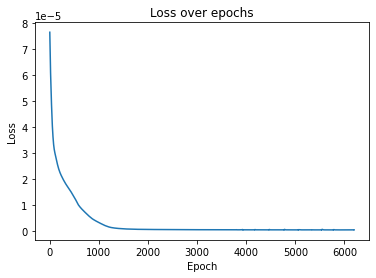

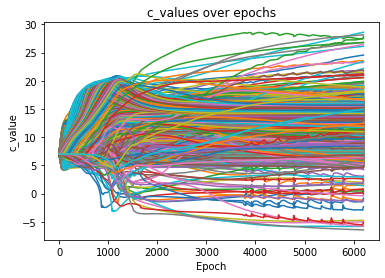

In [46]:
epochs = 1000

for n in range(epochs):
    if n % 100 == 0:  # Print every 100 epochs
        print('epochs:', n)
    optimizer.zero_grad()
    # Forward pass through the model
    output_list = [status_t0_tensor, status_t1_tensor]
    input1 = status_t1_tensor
    input2 = status_t0_tensor

    c = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)

    for _ in range(timesteps):
        output = model(input1, input2, c, sigma2)
        output_list.append(output[:,1:, :, :])
        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]

    # Concatenate the output list along the time dimension
    output_tensor = torch.cat(output_list, dim=1).squeeze(0)

    # # Compute the loss
    # loss = mse_loss(output_tensor, Obs_sensor_3d_array)

    # Index the output tensor at the sensor locations
    # print(output_tensor.shape)
    # output_at_sensors = output_tensor[:, sensor_indices]
    # print(output_at_sensors.shape)

    # # Index the observation tensor at the sensor locations
    # obs_at_sensors = Obs_sensor_3d_array[:, sensor_indices]

    # Index the output and observation tensors at the sensor locations
    output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
    obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

    # Compute the loss
    loss = mse_loss(output_at_sensors, obs_at_sensors)

    # Backward pass to calculate gradients
    loss.backward(retain_graph=True)

    losses.append(loss.item())

    # optimize C
    optimizer.step()
    c_values.append(c_forward1.tolist())

    # Log the loss and c_value to wandb
    log_dict = {"loss": loss.item()}
    log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward1.tolist())})
    wandb.log(log_dict)

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(c_values)
plt.title('c_values over epochs')
plt.xlabel('Epoch')
plt.ylabel('c_value')
plt.show()

[4.998856544494629, 4.997677326202393, 4.999093055725098, 4.9940266609191895, 5.000692844390869, 4.993526458740234, 5.000182628631592, 4.992828369140625, 4.998447418212891, 4.993194580078125, 4.998012065887451, 4.995048522949219, 4.996771812438965, 4.997755527496338, 4.995840549468994, 4.996824264526367, 4.997307777404785, 4.99580717086792, 4.996405124664307, 4.996520042419434, 4.9962382316589355, 4.997525691986084, 4.996932506561279, 4.997244358062744, 4.997657775878906, 4.9967732429504395, 4.997479438781738, 4.996937274932861, 4.996145248413086, 4.997018337249756, 4.9958815574646, 4.994913101196289, 4.9949469566345215, 4.99439811706543, 4.99453067779541, 4.995171546936035, 4.994839191436768, 4.994970321655273, 4.9960103034973145, 4.9961347579956055, 4.995820045471191, 4.9960222244262695, 4.995823860168457, 4.995227336883545, 4.9950127601623535, 4.9942731857299805, 4.993031024932861, 4.993228912353516, 4.993117332458496, 4.992700576782227, 4.994264602661133, 4.994348049163818, 4.99407

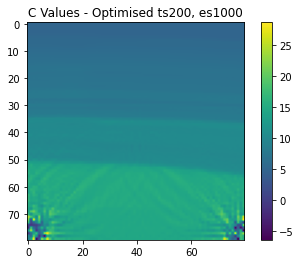

In [47]:
print(c_values[-1])
print(name)

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[4.999048709869385, 4.997544765472412, 4.99904203414917, 4.994205474853516, 5.0007524490356445, 4.9934916496276855, 5.000399112701416, 4.992583751678467, 4.998640060424805, 4.992980003356934, 4.99812126159668, 4.994924068450928, 4.996798038482666, 4.997368335723877, 4.995755672454834, 4.9966511726379395, 4.997059345245361, 4.995530605316162, 4.9962615966796875, 4.996280670166016, 4.996044158935547, 4.997303485870361, 4.996435165405273, 4.996873378753662, 4.9972968101501465, 4.996200084686279, 4.9971137046813965, 4.996511936187744, 4.995635986328125, 4.99678897857666, 4.995720863342285, 4.99477481842041, 4.994880199432373, 4.994265556335449, 4.994433403015137, 4.995193004608154, 4.994822025299072, 4.994826793670654, 4.995937824249268, 4.996201038360596, 4.995846748352051, 4.995884895324707, 4.995538711547852, 4.9948649406433105, 4.9945878982543945, 4.993727684020996, 4.992393970489502, 4.9927077293396, 4.992483615875244, 4.9919209480285645, 4.993669509887695, 4.993612766265869, 4.993298

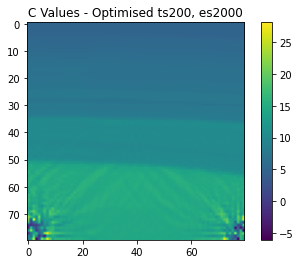

In [45]:
print(c_values[-1])
print(name)

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[4.997586250305176, 4.996833801269531, 4.9977874755859375, 4.9928669929504395, 5.00103759765625, 4.990126132965088, 5.002119064331055, 4.991429328918457, 4.99849271774292, 4.992297172546387, 4.9988694190979, 4.994644641876221, 4.996997356414795, 4.997415542602539, 4.99606466293335, 4.996930122375488, 4.997053146362305, 4.995293617248535, 4.9968132972717285, 4.996113300323486, 4.9962944984436035, 4.997983932495117, 4.995392799377441, 4.9969611167907715, 4.997153282165527, 4.994390487670898, 4.996756553649902, 4.995628356933594, 4.993845462799072, 4.996169090270996, 4.9947662353515625, 4.9937310218811035, 4.994663715362549, 4.994045257568359, 4.994231224060059, 4.9950056076049805, 4.994775772094727, 4.995392322540283, 4.9968085289001465, 4.9973578453063965, 4.9975266456604, 4.997363567352295, 4.996143341064453, 4.994611740112305, 4.993891716003418, 4.992219924926758, 4.990352630615234, 4.991502285003662, 4.991478443145752, 4.990264892578125, 4.992872714996338, 4.992021560668945, 4.991525

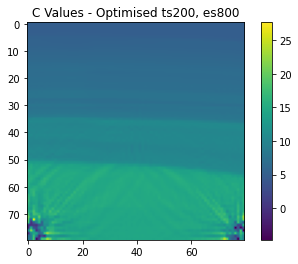

In [43]:
print(c_values[-1])
print(name)

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[4.998250961303711, 4.994338035583496, 4.997926712036133, 4.991532802581787, 5.001735687255859, 4.988083839416504, 5.00257682800293, 4.9901556968688965, 4.9984259605407715, 4.991218566894531, 4.999342918395996, 4.994117736816406, 4.99578332901001, 4.9974045753479, 4.995026588439941, 4.996419429779053, 4.996310234069824, 4.994020938873291, 4.997005939483643, 4.994699001312256, 4.996370792388916, 4.998188495635986, 4.993330001831055, 4.996808052062988, 4.996567726135254, 4.99293851852417, 4.996910572052002, 4.994456768035889, 4.99257755279541, 4.9952545166015625, 4.992794036865234, 4.991496562957764, 4.992186069488525, 4.991583824157715, 4.9922356605529785, 4.993254661560059, 4.9935173988342285, 4.9948225021362305, 4.996402740478516, 4.996920585632324, 4.997426509857178, 4.997506618499756, 4.995979309082031, 4.994154930114746, 4.9937334060668945, 4.9918389320373535, 4.989494323730469, 4.991104602813721, 4.990973949432373, 4.98923397064209, 4.992887020111084, 4.991449356079102, 4.99048519

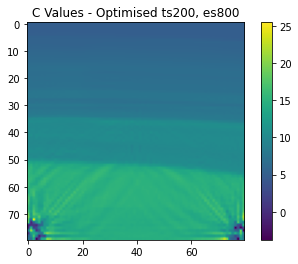

In [41]:
print(c_values[-1])
print(name)

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[5.002984523773193, 4.985577583312988, 4.999607563018799, 4.9846343994140625, 5.001617908477783, 4.983870029449463, 5.003169059753418, 4.987059116363525, 4.995510101318359, 4.996463298797607, 4.992748737335205, 4.9943928718566895, 4.993871688842773, 4.995203971862793, 4.992631435394287, 4.995548725128174, 4.995237827301025, 4.993680477142334, 5.000568389892578, 4.992282390594482, 4.9983906745910645, 4.997605323791504, 4.990062236785889, 4.996546268463135, 4.993854999542236, 4.993577480316162, 4.997900009155273, 4.992947578430176, 4.9921555519104, 4.992884635925293, 4.9891862869262695, 4.988260746002197, 4.988668441772461, 4.988145351409912, 4.988929271697998, 4.989919185638428, 4.9907989501953125, 4.99275541305542, 4.994020938873291, 4.994001865386963, 4.9943952560424805, 4.994542121887207, 4.993666648864746, 4.9913530349731445, 4.990997791290283, 4.990779399871826, 4.9876017570495605, 4.988006114959717, 4.988397121429443, 4.985482692718506, 4.989633083343506, 4.988251209259033, 4.9864

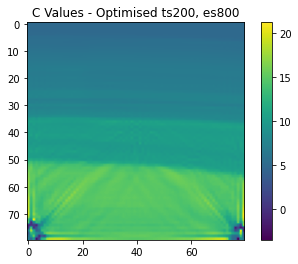

In [39]:
print(c_values[-1])
print(name)

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[4.997065544128418, 5.005202770233154, 5.006581783294678, 5.003101348876953, 4.9959259033203125, 4.989570617675781, 4.9872822761535645, 4.987626075744629, 4.986612796783447, 4.983771324157715, 4.982116222381592, 4.97604513168335, 4.974636554718018, 4.969601631164551, 4.965783596038818, 4.968869209289551, 5.561071872711182, 5.5672688484191895, 5.534720420837402, 5.5084967613220215, 5.531450271606445, 5.557126522064209, 5.554497241973877, 5.547673225402832, 5.558978080749512, 5.565911769866943, 5.563919544219971, 5.550685882568359, 5.534572601318359, 5.498064041137695, 5.4466986656188965, 5.407413959503174, 6.228795051574707, 6.233837127685547, 6.213199138641357, 6.188320636749268, 6.217141151428223, 6.249013900756836, 6.246191501617432, 6.222711086273193, 6.202566623687744, 6.183373928070068, 6.169164657592773, 6.148674011230469, 6.129702091217041, 6.098311901092529, 6.0696024894714355, 6.041973114013672, 6.837716102600098, 6.857080936431885, 6.92512321472168, 6.926436424255371, 6.80917

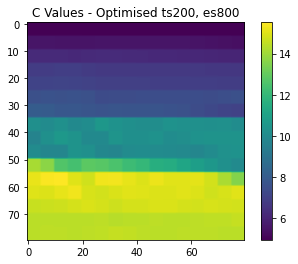

In [126]:
print(c_values[-1])
print(name)

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[4.997535228729248, 4.995266437530518, 4.994495391845703, 4.999351978302002, 4.997706890106201, 4.9975762367248535, 4.996912956237793, 4.99651575088501, 4.998401641845703, 4.997994899749756, 4.997694969177246, 4.996679306030273, 4.995969295501709, 4.9961652755737305, 4.99424409866333, 4.994448184967041, 4.993182182312012, 4.994746685028076, 4.994091510772705, 4.995912075042725, 4.995543003082275, 4.995412349700928, 4.993352890014648, 4.99408483505249, 4.995040416717529, 4.995116710662842, 4.995547294616699, 4.996914863586426, 4.997244834899902, 4.999075889587402, 5.000607967376709, 5.00116491317749, 5.001845359802246, 5.003605842590332, 5.001163005828857, 5.004593372344971, 5.0009918212890625, 5.005295276641846, 5.003030300140381, 5.007175922393799, 4.9868574142456055, 4.984014987945557, 4.984474182128906, 4.985079288482666, 4.986910820007324, 4.987800121307373, 4.9899749755859375, 4.988683700561523, 4.988309383392334, 4.985679626464844, 4.9851555824279785, 4.984795570373535, 4.9855394

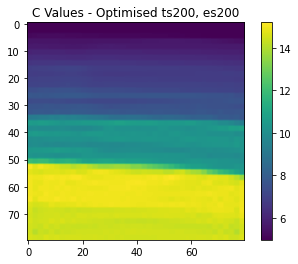

In [122]:
print(c_values[-1])
print(name)

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[4.997533798217773, 4.995263576507568, 4.994494915008545, 4.999361991882324, 4.997720718383789, 4.997600555419922, 4.99693489074707, 4.996542930603027, 4.998425483703613, 4.997993469238281, 4.997685432434082, 4.9966721534729, 4.995957374572754, 4.996154308319092, 4.9942307472229, 4.9944376945495605, 4.993176460266113, 4.994743824005127, 4.994097709655762, 4.995917320251465, 4.995539665222168, 4.995408535003662, 4.993358612060547, 4.994067668914795, 4.995011329650879, 4.995082378387451, 4.995512962341309, 4.99690055847168, 4.99724006652832, 4.999089241027832, 5.000632286071777, 5.001197814941406, 5.001874923706055, 5.003643989562988, 5.001181602478027, 5.004604339599609, 5.001003742218018, 5.005308151245117, 5.003021717071533, 5.007200241088867, 4.986874580383301, 4.984022617340088, 4.984476089477539, 4.985084533691406, 4.986922264099121, 4.987797260284424, 4.9899749755859375, 4.988667964935303, 4.988290309906006, 4.985677719116211, 4.985174179077148, 4.984816074371338, 4.98555946350097

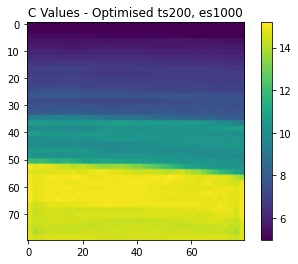

In [120]:
print(c_values[-1])
print(name)

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[6.9799628257751465, 6.90174674987793, 6.600783348083496, 6.048106670379639, 5.285958290100098, 4.980541229248047, 4.990543365478516, 5.000067234039307, 4.99657678604126, 5.002410411834717, 4.999031066894531, 4.99764347076416, 4.997923851013184, 4.996979236602783, 4.996877193450928, 4.996853828430176, 4.995951175689697, 4.995585918426514, 4.99541711807251, 4.9956841468811035, 4.995779514312744, 4.996492385864258, 4.995903015136719, 4.997196197509766, 4.997921466827393, 4.9981279373168945, 4.997367858886719, 4.999923229217529, 4.998675346374512, 5.000901699066162, 5.002809524536133, 4.9998931884765625, 5.0057902336120605, 4.995707035064697, 5.007627964019775, 5.468469142913818, 6.258425712585449, 6.686561584472656, 6.911870956420898, 6.974881172180176, 6.781449317932129, 6.386682510375977, 5.575987815856934, 4.95368766784668, 4.855847358703613, 4.9470367431640625, 4.9900431632995605, 4.992127895355225, 4.9871907234191895, 4.984541416168213, 4.979191303253174, 4.982428550720215, 4.982749

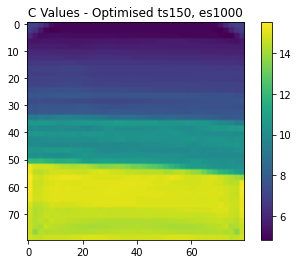

In [115]:
print(c_values[-1])
print(name)

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[3.529337167739868, 3.6472396850585938, 4.001567840576172, 4.589859962463379, 4.971625804901123, 4.99959135055542, 4.99386739730835, 4.9982476234436035, 4.9956583976745605, 5.000589847564697, 4.998466968536377, 4.996614456176758, 4.997269153594971, 4.996638774871826, 4.9967451095581055, 4.996776103973389, 4.996081829071045, 4.996054172515869, 4.995920181274414, 4.996182918548584, 4.996258735656738, 4.996903419494629, 4.996156692504883, 4.996995449066162, 4.997550010681152, 4.997873306274414, 4.997127056121826, 4.9994306564331055, 4.997886657714844, 5.00037956237793, 5.000710487365723, 4.999213695526123, 5.003231525421143, 5.003084659576416, 5.014016628265381, 4.938687801361084, 4.460186004638672, 3.876012086868286, 3.594083309173584, 3.518474578857422, 3.7631261348724365, 4.224356174468994, 4.80656099319458, 5.032651424407959, 5.0040507316589355, 4.982170581817627, 4.982715129852295, 4.987605094909668, 4.987164497375488, 4.985018253326416, 4.979923725128174, 4.982030391693115, 4.982943

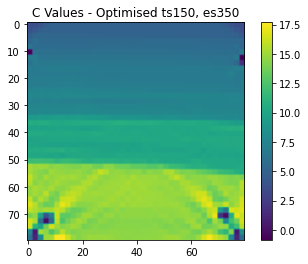

In [112]:
print(c_values[-1])
print(name)

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[3.5208890438079834, 3.6075778007507324, 3.8904104232788086, 4.436200141906738, 4.910274505615234, 5.001378059387207, 4.995349884033203, 4.997629165649414, 4.995206832885742, 4.999741554260254, 4.997851371765137, 4.995839595794678, 4.996796607971191, 4.996630668640137, 4.996740818023682, 4.996785640716553, 4.996119499206543, 4.9961042404174805, 4.9959893226623535, 4.996260643005371, 4.996287822723389, 4.9968390464782715, 4.996006965637207, 4.996945858001709, 4.99750280380249, 4.9978790283203125, 4.997065544128418, 4.999007225036621, 4.99728536605835, 5.000121116638184, 5.0001349449157715, 4.999080181121826, 5.002459526062012, 5.006002902984619, 5.011478900909424, 4.85618782043457, 4.311758995056152, 3.789651870727539, 3.5680480003356934, 3.5128002166748047, 3.6971077919006348, 4.097343444824219, 4.692235469818115, 5.009098529815674, 5.027096748352051, 4.988300800323486, 4.9816107749938965, 4.986140727996826, 4.987305164337158, 4.9844794273376465, 4.979030609130859, 4.981330871582031, 4

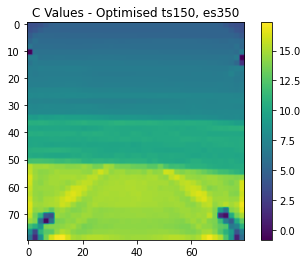

In [110]:
print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[3.5123229026794434, 3.565826416015625, 3.761399507522583, 4.216127395629883, 4.766283988952637, 4.981992244720459, 4.999472618103027, 4.995580196380615, 4.993785381317139, 4.998294353485107, 4.997722148895264, 4.9936747550964355, 4.995329856872559, 4.99609899520874, 4.9963178634643555, 4.997082710266113, 4.996671199798584, 4.996642112731934, 4.996720790863037, 4.996953010559082, 4.996824264526367, 4.9971113204956055, 4.995920181274414, 4.9971604347229, 4.9977874755859375, 4.997653961181641, 4.99678897857666, 4.997081279754639, 4.994816303253174, 4.99885368347168, 4.998779296875, 4.998368263244629, 5.001298427581787, 5.0114617347717285, 4.9744791984558105, 4.69045352935791, 4.109883785247803, 3.692244529724121, 3.5412895679473877, 3.5072021484375, 3.624577760696411, 3.9330787658691406, 4.492469310760498, 4.920031547546387, 5.046171188354492, 5.010400772094727, 4.983425617218018, 4.9820122718811035, 4.986080646514893, 4.9873762130737305, 4.981863975524902, 4.982580184936523, 4.986488342

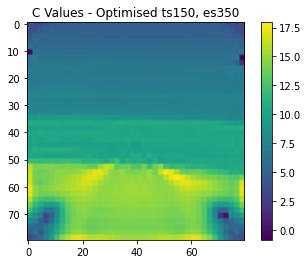

In [108]:
print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[3.503675937652588, 3.522529125213623, 3.608847141265869, 3.8774666786193848, 4.391284465789795, 4.813952922821045, 4.973178863525391, 5.01185417175293, 4.9987287521362305, 5.006598472595215, 5.011408805847168, 5.006892681121826, 5.004448413848877, 5.006224155426025, 5.009420394897461, 5.010387897491455, 5.010077476501465, 5.010038375854492, 5.009461879730225, 5.008625030517578, 5.00886869430542, 5.010245323181152, 5.009000778198242, 5.009711265563965, 5.009058952331543, 5.007761001586914, 5.005301475524902, 5.007209300994873, 5.006066799163818, 5.011325836181641, 5.00924825668335, 5.00316047668457, 5.016739845275879, 4.964702606201172, 4.754591941833496, 4.298839092254639, 3.81326961517334, 3.58012056350708, 3.514437437057495, 3.502009391784668, 3.543255567550659, 3.701901435852051, 4.0943827629089355, 4.604060173034668, 4.948132038116455, 5.05692720413208, 5.048528671264648, 5.0044426918029785, 4.983750343322754, 4.985393047332764, 4.981184482574463, 4.97621488571167, 4.9806499481201

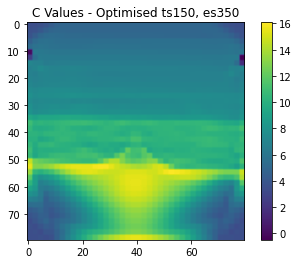

In [106]:
print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[3.5008554458618164, 3.521696090698242, 3.7293436527252197, 4.511570930480957, 4.989740371704102, 4.999773025512695, 4.99813175201416, 4.999858856201172, 5.00014591217041, 4.997643947601318, 5.001418113708496, 5.00034236907959, 4.997803211212158, 4.998353004455566, 4.998293876647949, 4.995827674865723, 4.995917320251465, 4.995938301086426, 4.996238708496094, 4.996288299560547, 4.996096611022949, 4.997136116027832, 4.99777364730835, 4.998878002166748, 5.000025272369385, 5.001315116882324, 5.000946521759033, 5.001386642456055, 5.003754138946533, 5.006240367889404, 5.005774021148682, 5.004541873931885, 5.002533912658691, 4.997658729553223, 4.998004913330078, 4.952343463897705, 4.285616874694824, 3.5955991744995117, 3.5002944469451904, 3.5, 3.5751969814300537, 4.087625980377197, 4.877424716949463, 5.0035400390625, 4.981444358825684, 4.9696831703186035, 4.979255676269531, 4.983181476593018, 4.985680103302002, 4.987913131713867, 4.991530895233154, 4.991026878356934, 4.989621162414551, 4.9858

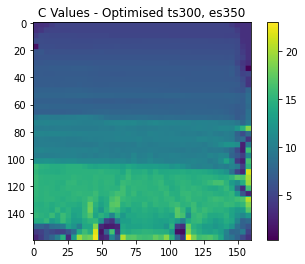

In [94]:
print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[3.5001676082611084, 3.5043678283691406, 3.5851409435272217, 4.126645565032959, 4.956186294555664, 5.015849590301514, 5.001431941986084, 5.001121520996094, 4.997034072875977, 4.995154857635498, 4.996355056762695, 4.99660587310791, 4.9958953857421875, 4.996102333068848, 4.994195938110352, 4.991997241973877, 4.992656707763672, 4.992310047149658, 4.991513729095459, 4.991458415985107, 4.993228435516357, 4.9931793212890625, 4.993912696838379, 4.995553016662598, 4.993849754333496, 4.994279861450195, 4.994555950164795, 4.99324369430542, 4.993518829345703, 4.992923259735107, 4.99302864074707, 4.993989944458008, 4.996118068695068, 4.996880531311035, 4.997044086456299, 4.998640537261963, 4.9968390464782715, 4.996421813964844, 4.996850967407227, 4.999079704284668, 4.996095657348633, 5.000118732452393, 5.002567768096924, 5.000447750091553, 5.018887519836426, 4.865484237670898, 3.9840638637542725, 3.55751633644104, 3.5021862983703613, 3.500046968460083, 3.5031886100769043, 3.5697021484375, 4.074388

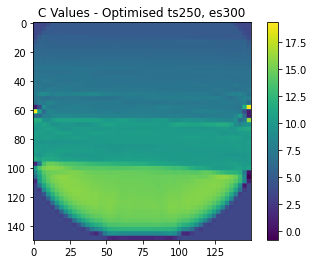

In [82]:
print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[3.50003719329834, 3.501222848892212, 3.5357728004455566, 3.829481840133667, 4.651756763458252, 5.022794723510742, 5.0031046867370605, 5.004271984100342, 4.999544620513916, 4.995629787445068, 4.995574951171875, 4.996010780334473, 4.995517730712891, 4.99609375, 4.993985176086426, 4.991330623626709, 4.991555690765381, 4.990790843963623, 4.989491939544678, 4.989204406738281, 4.991058349609375, 4.991165637969971, 4.99202823638916, 4.993473529815674, 4.991599082946777, 4.9919867515563965, 4.99231481552124, 4.991063594818115, 4.9911699295043945, 4.990329742431641, 4.990368366241455, 4.991579532623291, 4.994235515594482, 4.995261192321777, 4.995970726013184, 4.998268127441406, 4.996635913848877, 4.995912075042725, 4.996163368225098, 4.998118877410889, 4.996535301208496, 5.002268314361572, 5.004602432250977, 5.002460956573486, 5.009716510772705, 4.523909091949463, 3.7405271530151367, 3.5228776931762695, 3.5007035732269287, 3.5, 3.500746488571167, 3.526879072189331, 3.7948975563049316, 4.608215

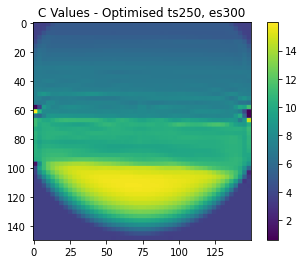

In [80]:
print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[4.994240760803223, 4.9974751472473145, 4.9976372718811035, 4.997908115386963, 5.002042770385742, 5.005068302154541, 5.007339954376221, 5.005245685577393, 5.0065531730651855, 5.009397983551025, 5.011293888092041, 5.013926029205322, 5.016895294189453, 5.0189528465271, 5.02169942855835, 5.021856784820557, 5.023209095001221, 5.025651454925537, 5.026921272277832, 5.028663158416748, 5.028534889221191, 5.0317206382751465, 5.035135269165039, 5.034753799438477, 5.035425662994385, 5.034413814544678, 5.03648042678833, 5.036233901977539, 5.032954216003418, 5.030148506164551, 5.031445503234863, 5.0336689949035645, 5.035844326019287, 5.035683631896973, 5.037876129150391, 5.038411617279053, 5.038720607757568, 5.037701606750488, 5.037905216217041, 5.0342278480529785, 5.029418468475342, 5.025363445281982, 5.022732257843018, 5.021172523498535, 5.020632743835449, 5.020133972167969, 5.020610809326172, 5.011703014373779, 5.002896785736084, 4.99384880065918, 5.005295276641846, 5.010927200317383, 5.00261306

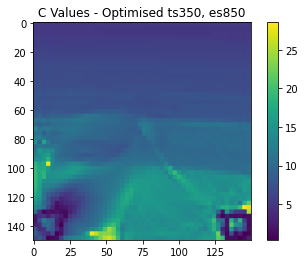

In [72]:
print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[3.9020204544067383, 4.568368911743164, 4.978187561035156, 4.998249530792236, 4.9993414878845215, 4.999390602111816, 5.000152587890625, 5.001470565795898, 5.0029826164245605, 5.002962112426758, 5.0031538009643555, 5.002924919128418, 5.003287315368652, 5.00383186340332, 5.004151344299316, 5.003302574157715, 5.0041656494140625, 5.00332498550415, 5.001135349273682, 5.00179386138916, 5.00088357925415, 5.001012325286865, 5.000740051269531, 4.999485015869141, 4.998169898986816, 4.998119831085205, 4.998179912567139, 4.997507572174072, 4.997419357299805, 4.996547222137451, 4.996553421020508, 4.998847484588623, 5.002126693725586, 5.002594470977783, 5.0029401779174805, 5.003427505493164, 5.002554416656494, 5.001853942871094, 5.002738952636719, 5.002528667449951, 5.0030517578125, 5.003170490264893, 5.002374172210693, 5.001723766326904, 5.000171184539795, 4.999292373657227, 5.000411033630371, 4.9061479568481445, 4.326784610748291, 3.7561302185058594, 4.917520999908447, 5.08352518081665, 5.04679298

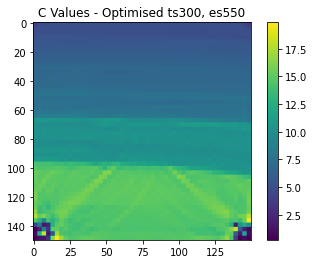

In [66]:
#  150*150  50*50

print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[4.896451473236084, 4.934471607208252, 4.954509258270264, 4.9682440757751465, 4.974724292755127, 4.977846145629883, 4.975775718688965, 4.977651596069336, 4.977500915527344, 4.979565143585205, 4.980313777923584, 4.977715969085693, 4.978298664093018, 4.979710102081299, 4.979371547698975, 4.98160982131958, 4.982415676116943, 4.982120513916016, 4.987275123596191, 4.989652633666992, 4.993016242980957, 4.994320869445801, 4.998238563537598, 4.997852325439453, 5.013284206390381, 5.244093894958496, 5.242859840393066, 5.2344970703125, 5.236364841461182, 5.22574520111084, 5.203195571899414, 5.180522918701172, 5.1675848960876465, 5.151323318481445, 5.144145965576172, 5.134461879730225, 5.138359546661377, 5.140150547027588, 5.132272243499756, 5.124273300170898, 5.111851692199707, 5.09923791885376, 5.084033966064453, 5.061405181884766, 5.056396961212158, 5.033355236053467, 5.020217418670654, 4.999915599822998, 4.992742538452148, 4.955498695373535, 5.607731819152832, 5.624418258666992, 5.608785629272

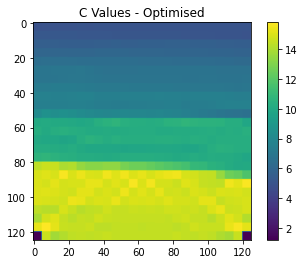

In [54]:
# timestep 250, epochs 550, 125*125, 25*25

print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised ts{}, es{}'.format(timesteps, epochs))
plt.show()

[4.891641139984131, 4.934441089630127, 4.954569339752197, 4.968226909637451, 4.974569797515869, 4.977649688720703, 4.975606441497803, 4.977367877960205, 4.977237224578857, 4.979342937469482, 4.980092525482178, 4.977426528930664, 4.978025436401367, 4.9794745445251465, 4.97921085357666, 4.981398582458496, 4.982338905334473, 4.981992721557617, 4.987217426300049, 4.989633560180664, 4.992967128753662, 4.994213104248047, 4.99826717376709, 4.998814105987549, 4.9406867027282715, 5.2446208000183105, 5.243252754211426, 5.2345194816589355, 5.236415863037109, 5.225541114807129, 5.202761650085449, 5.180174350738525, 5.167628765106201, 5.151638031005859, 5.144558429718018, 5.134881973266602, 5.138874530792236, 5.140600204467773, 5.132782936096191, 5.124659061431885, 5.112225532531738, 5.099575042724609, 5.084104537963867, 5.061273574829102, 5.0561842918396, 5.0331525802612305, 5.020232677459717, 4.9996209144592285, 4.996708393096924, 4.95871639251709, 5.60783576965332, 5.624549388885498, 5.608549594

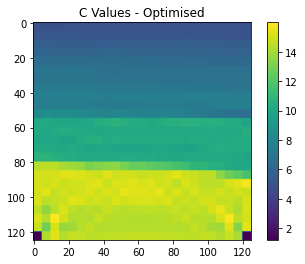

In [52]:
# timestep 250, epochs 300

print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised')
plt.show()

[2.9333226680755615, 2.8927292823791504, 2.2886738777160645, 1.8747575283050537, 4.874197006225586, 5.5897064208984375, 5.791234493255615, 5.745731353759766, 5.7786126136779785, 5.882936000823975, 5.713339805603027, 5.498224258422852, 4.822246551513672, 4.123226165771484, 2.1907193660736084, 1.938114881515503, 2.552781820297241, 3.1473615169525146, 4.441721439361572, 5.624477863311768, 4.951159954071045, 5.182107448577881, 5.101553440093994, 4.8042144775390625, 4.887252330780029, 3.9026336669921875, 4.173125743865967, 6.0134382247924805, 6.20166540145874, 6.3438801765441895, 6.368585586547852, 6.359447956085205, 6.333782196044922, 6.316109657287598, 6.305051803588867, 6.298711776733398, 6.309972286224365, 6.286518096923828, 6.211481094360352, 6.109302520751953, 5.778172969818115, 5.295611381530762, 3.7062177658081055, 2.643387794494629, 3.537036895751953, 4.641652584075928, 4.7179741859436035, 4.47874116897583, 4.796215057373047, 4.729788780212402, 5.946822643280029, 6.574619293212891,

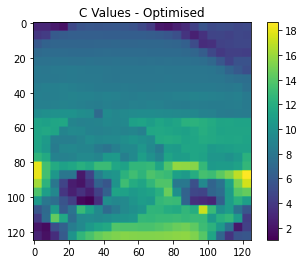

In [46]:
# timestep 500

print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised')
plt.show()

[5.534952640533447, 5.487608909606934, 5.476341247558594, 5.488800048828125, 5.429932594299316, 7.134279727935791, 7.070113182067871, 7.064653396606445, 6.9925618171691895, 6.934337615966797, 10.181180000305176, 9.98120403289795, 9.911724090576172, 9.827110290527344, 9.496881484985352, 13.57795238494873, 13.421446800231934, 13.188094139099121, 12.972708702087402, 12.653763771057129, 14.786600112915039, 14.922499656677246, 14.980419158935547, 14.955592155456543, 14.953659057617188]


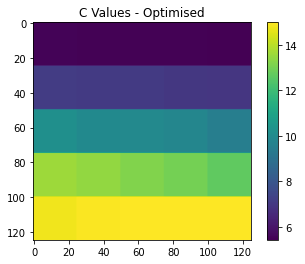

In [40]:
print(c_values[-1])

c_show = create_checkerboard(c_forward1, xysize, xysize, number_rows, number_cols)
plt.imshow(c_show.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Optimised')
plt.show()

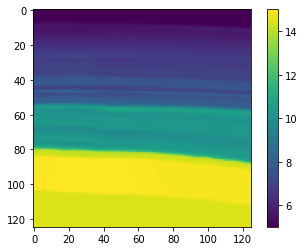

In [ ]:
plt.imshow(scaled_data)
plt.colorbar()

#### Visualise computational graph

In [32]:
mse_loss = nn.MSELoss()

# C guess
C_guess_value = 3.5
c_forward1 = torch.tensor([C_guess_value]*5, dtype=torch.float32, device=device, requires_grad=True)

# lr = 0.1
lr = 0.1

# Use Adam optimizer
optimizer = torch.optim.Adam([c_forward1], lr)
c_values = [c_forward1.tolist()]

losses = []

# Move clone operation outside the loop
Obs_sensor_3d_array = Status_List_stacked_obs.clone()

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

for n in range(1):
    if n % 100 == 0:  # Print every 100 epochs
        print('epochs:', n)
    optimizer.zero_grad()
    # Forward pass through the model
    output_list = [status_t0_tensor, status_t1_tensor]
    input1 = status_t1_tensor
    input2 = status_t0_tensor
    for _ in range(timesteps):
        output = model(input1, input2, c_forward1, sigma2)
        output_list.append(output[:,1:, :, :])
        input1 = output[:,1:, :, :]
        input2 = output[:,0:1, :, :]

    # Concatenate the output list along the time dimension
    output_tensor = torch.cat(output_list, dim=1).squeeze(0)

    # # Compute the loss
    # loss = mse_loss(output_tensor, Obs_sensor_3d_array)

    # Index the output tensor at the sensor locations
    # print(output_tensor.shape)
    # output_at_sensors = output_tensor[:, sensor_indices]
    # print(output_at_sensors.shape)

    # # Index the observation tensor at the sensor locations
    # obs_at_sensors = Obs_sensor_3d_array[:, sensor_indices]

    # Index the output and observation tensors at the sensor locations
    output_at_sensors = output_tensor[:, x_coords, y_coords].squeeze()
    obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords].squeeze()

    # Compute the loss
    loss = mse_loss(output_at_sensors, obs_at_sensors)

    print(loss.item())

epochs: 0
1.0926937523206282e-12


In [33]:
from torchviz import make_dot

# Visualize the computational graph
dot = make_dot(loss, params={'c_values': c_forward1})

dot.render(filename='graph_smallmodel', format='pdf')

'graph_smallmodel.pdf'